In [1]:
from netCDF4 import Dataset
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import warnings
import matplotlib.path as mpath
import cartopy.feature

theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

def axku(ax1):
    ax1.set_extent([-180, 180, -90, -30], ccrs.PlateCarree())
    ax1.set_boundary(circle, transform=ax1.transAxes)
    ax1.gridlines()
    ax1.add_feature(cartopy.feature.COASTLINE)

In [2]:
### Extract data from GEOTRACES IDP 2021 - Dissolved Manganese

fname="GEOTRACES_IDP2021_Slim_Seawater_Discrete_Sample_Data_v1.nc"
ncfile= xr.open_dataset(fname)
### there are 3174 stations and 698 samples
# extract lat, lon, depth, and conc of dMn
Lon = ncfile['longitude'][:]
Lat = ncfile['latitude'][:]
Depth= ncfile['var2'][:]
DMN_bottle= ncfile['var101'][:]

/opt/anaconda3/envs/newsie/lib/python3.9/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'rasterio' loading failed:
dlopen(/opt/anaconda3/envs/newsie/lib/python3.9/site-packages/rasterio/_base.cpython-39-darwin.so, 0x0002): Symbol not found: _ZSTD_compressBound
  Referenced from: /opt/anaconda3/envs/newsie/lib/libgdal.30.dylib
  Expected in: /opt/anaconda3/envs/newsie/lib/libblosc.1.21.1.dylib
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
## Extract data from PISCES-QUOTA output (averaged over the year)
fnamep= "transporter2_1m_ptrc_Y1100.nc"
ncfilep= xr.open_dataset(fnamep)
DMN_model= ncfilep['DMN'].mean('time_counter')
nav_lon = ncfilep['nav_lon']
nav_lat = ncfilep['nav_lat']

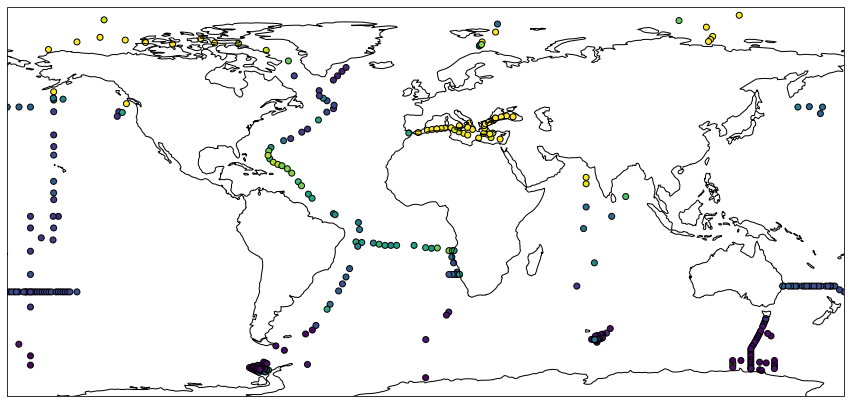

In [4]:
fig=plt.figure()
fig.set_size_inches(15,12)
import cartopy.feature as cfeature
grid1 = plt.GridSpec(1, 1)
aci= fig.add_subplot(grid1[0, 0], projection= ccrs.PlateCarree())
aci.add_feature(cfeature.COASTLINE)

alldmn=[]
allons=[]
allats=[]
for sli in range(698):
    # find which depth I want to compare, e,g between 10-15m
    deeploc= np.where(np.logical_and(Depth[:,sli]>=10, Depth[:,sli]<=15))
    # only allow stations with more than 5 datapoints
    if np.size(deeploc)>5:
        # find lat,lon, and dMn which has samples at 10-15m
        Lons= Lon[deeploc]
        Lats= Lat[deeploc]
        dmn_bot= DMN_bottle[:,sli]
        dmn_bottle= dmn_bot[deeploc]
        dmn_bottles= dmn_bottle[~np.isnan(dmn_bottle)]
        Lons1=Lons[~np.isnan(dmn_bottle)]
        Lats1=Lats[~np.isnan(dmn_bottle)]
        if np.size(Lats1)>=1:
            # append all geotraces data that are taken between 10-15m
            alldmn.append(np.array(dmn_bottles))
            allons.append(np.array(Lons1))
            allats.append(np.array(Lats1))
            # plot where these data are
            c=aci.scatter(Lons1, Lats1, transform=ccrs.PlateCarree(), c=dmn_bottles, vmin=0, vmax=4, edgecolors='black')


In [5]:
# Extract modelled dMn at 15m
dmn15= DMN_model.isel(deptht=1)

#untangle them into a single array
nav_lats= np.reshape(nav_lat,(1,149*182))
nav_lons= np.reshape(nav_lon,(1,149*182))
dmn_model= np.reshape(dmn15,(1,149*182))

nav_lata=np.array(nav_lats)
nav_longa=np.array(nav_lons)
dmn_modela= np.array(dmn_model)

dmns_matches=[]
lons_matches=[]
lats_matches=[]


dmns_insitus=[]
lons_insitus=[]
lats_insitus=[]

# find matching lat and lon with observation
for i in range(len(allats)):

    allons01= allons[i]
    allats0= allats[i]
    alldmn0= alldmn[i]

    allons0=[]
    for a in allons01:
        if a > 180:
            a = a - 360
        else:
            a = a
        allons0.append(a)
    
    dmn_match=[]
    dmn_insitu=[]
    modelon=[]
    modelat=[]
    lat_insitu=[]
    lon_insitu=[]
    for t, ts in enumerate(allats0):
        # find matching model lat with observation
        locat=(np.abs(nav_lata-ts)).argmin()
        nearest=nav_lata[0,locat]
        
        locat2=np.where(nav_lata==nearest)
        nlat=nav_lata[locat2]
        dmnlat=dmn_modela[locat2]
        nlon= nav_longa[locat2]
        # find matching model lat with obs
        selisih=(np.abs(nlon - allons0[t])).min() 
        # only allow those that differ 5deg
        if selisih < 5:
            locon=(np.abs(nlon-allons0[t])).argmin()
            nearestlon= nlon[locon]
            
            locon2=np.where(nearestlon==nlon)
            nlon1= nlon[locon2]
            nlat1= nlat[locon2]
            # find the dmn that's in the nearest obs lat and lon, then append. 
            dmnmatch= dmnlat[locon2]
            dmn_match.append(dmnmatch[0])
            modelon.append(nlon1[0])
            modelat.append(nlat1[0])
            # this is where the in situ match with model
            dmn_insitu.append(alldmn0[t])
            lat_insitu.append(allats0[t])
            lon_insitu.append(allons0[t])
    
    ## get rid of all the Nans
    dmn_matches1= np.array(dmn_match)
    dmn_matches=(dmn_matches1[~np.isnan(dmn_matches1)])
    lat_matches1= np.array(modelat)
    lat_matches=(lat_matches1[~np.isnan(dmn_matches1)])
    lon_matches1= np.array(modelon)
    lon_matches=(lon_matches1[~np.isnan(dmn_matches1)])
    
    
    dmn_insitu= np.array(dmn_insitu)
    dmn_insitus= (dmn_insitu[~np.isnan(dmn_matches1)])
    lat_insitu= np.array(lat_insitu)
    lat_insitus= (lat_insitu[~np.isnan(dmn_matches1)])
    lon_insitu= np.array(lon_insitu)
    lon_insitus= (lon_insitu[~np.isnan(dmn_matches1)])
    
    # append all of them
    if len(dmn_matches) > 3:
        dmns_matches.append(dmn_matches)
        dmns_insitus.append(dmn_insitus)
        lats_insitus.append(lat_insitus)
        lons_insitus.append(lon_insitus)
        lats_matches.append(lat_matches)
        lons_matches.append(lon_matches)

import itertools
array_dmnmod=(list(itertools.chain.from_iterable(dmns_matches)))
array_dmnsitu=(list(itertools.chain.from_iterable(dmns_insitus)))
array_lasitu=(list(itertools.chain.from_iterable(lats_insitus)))
array_lositu=(list(itertools.chain.from_iterable(lons_insitus)))

array_lamod=(list(itertools.chain.from_iterable(lats_matches)))
array_lomod=(list(itertools.chain.from_iterable(lons_matches)))

## These are the arrays we can compare at 5m
array_dmnmod= np.array(array_dmnmod)
array_lamod= np.array(array_lamod)
array_lomod= np.array(array_lomod)

array_dmnsitu= np.array(array_dmnsitu)
array_lositu= np.array(array_lositu)
array_lasitu= np.array(array_lasitu)

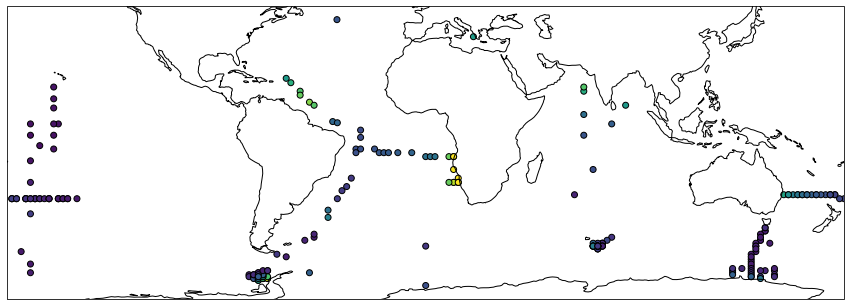

In [6]:
## check if the extracted model dMn match with the obs dMn location
fig=plt.figure()
fig.set_size_inches(15,12)
grid1 = plt.GridSpec(1, 1)
aci= fig.add_subplot(grid1[0, 0], projection= ccrs.PlateCarree())
aci.add_feature(cfeature.COASTLINE)

c=aci.scatter(array_lomod, array_lamod, transform=ccrs.PlateCarree(), c=array_dmnmod, vmin=0, vmax=4, edgecolors='black')



In [7]:
## find correlation 
correlation=np.corrcoef(array_dmnmod, array_dmnsitu)
rmsd=np.sqrt(np.mean((array_dmnmod - array_dmnsitu)**2))
print('ALL DMNs', 'corr=', correlation[1,0], 'rmsd=', rmsd, 'mean dMn model=', np.mean(array_dmnmod), 'mean dMn obs=', np.mean(array_dmnsitu))
corel=correlation[1,0]

ALL DMNs corr= 0.5536190284186301 rmsd= 0.9342664 mean dMn model= 1.1071569 mean dMn obs= 0.9931019


Text(0.5, 1.0, ' corr=0.554 rmsd=0.934')

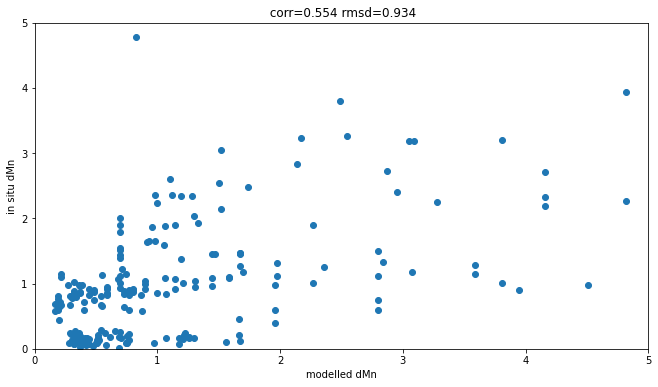

In [8]:
fig2= plt.figure()
fig2.set_size_inches(11,6)
ax2=plt.subplot(111)
fig2.patch.set_facecolor('xkcd:white')
ax2.plot(array_dmnmod, array_dmnsitu, 'o')
ax2.set_ylabel('in situ dMn')
ax2.set_xlabel('modelled dMn')
ax2.set_xlim(0,5)
ax2.set_ylim(0,5)
title_=' corr=%1.3f'%corel+' rmsd=%1.3f'%rmsd
ax2.set_title(title_)